# Modeling Notebook - Adapted From reddit binary classification

We sprint through some things here to see if we can get to some sort of MVP on our capstone so we can then begin trying to improve upon things.

In [1]:
#Grabbing some mates

import warnings #I receive an unsightly deprecation warning for matplotlib. This suppresses it
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import BernoulliNB
from pandas_profiling import ProfileReport

from nltk.util import ngrams



from sklearn.feature_extraction import text

#### Importing my pulled data

In [2]:
bechdel_df = pd.read_csv('../data/bechdel_df.csv')

In [3]:
bechdel_df.head()

,Unnamed: 0,textscript,rating,title,year,imdbid,simple_bechdel
0,0,WARRIOR ...,1,warrior,2011,1291584.0,0
1,5,GAMER ...,1,gamer,2009,1034032.0,0
2,6,WANTED ...,1,wanted,2008,493464.0,0
3,7,2001: A SPACE ODYSSEY Screenplay by ...,0,2001: a space odyssey,1968,62622.0,0
4,8,CRUEL INTENTIONS ...,3,cruel intentions,1999,139134.0,1


Here we are going to keep the features that we are going to use going forward.

In [4]:
bechdel_df = bechdel_df[['textscript', 'title', 'simple_bechdel']]

In [5]:
bechdel_df.head()

,textscript,title,simple_bechdel
0,WARRIOR ...,warrior,0
1,GAMER ...,gamer,0
2,WANTED ...,wanted,0
3,2001: A SPACE ODYSSEY Screenplay by ...,2001: a space odyssey,0
4,CRUEL INTENTIONS ...,cruel intentions,1


In [6]:
bechdel_df.set_index('title')

,textscript,simple_bechdel
title,,
warrior,WARRIOR ...,0
gamer,GAMER ...,0
wanted,WANTED ...,0
2001: a space odyssey,2001: A SPACE ODYSSEY Screenplay by ...,0
cruel intentions,CRUEL INTENTIONS ...,1
...,...,...
shakespeare in love,SHAKESPEARE IN LOVE ...,1
surrogates,SURROGATES ...,0
smashed,SMASHED ...,1


In [6]:
# Derya Gumustel and Amir Semsarzadeh helped out and we created a function to do a lot of RegEx cleaning
def clean_this_data_please(df):
    # remove those NaNs
    clean_df = df
    clean_df.replace(r'[^a-zA-Z ]\s?',' ',regex=True, inplace=True)
    clean_df.replace(np.nan, " ", regex=True, inplace=True)
    # remove links
    clean_df.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True, inplace=True)
    # remove digits, '&amp;', and forward slashes
    clean_df.replace('\d+', '', regex=True, inplace=True) # help from Amir! 
    clean_df.replace('&amp;', ' ', regex=True, inplace=True)
    clean_df.replace('/', ' ', regex=True, inplace=True)
    # remove new line characters
    clean_df.replace(to_replace=[r'\\t|\\n|\\r', '\t|\n|\r'], value=[' ',' '], regex=True, inplace=True)
    #gotta remove [removed]
    df.replace(r'removed', " ", regex=True, inplace=True)
    return clean_df

#### We have some additional stop words that need to be removed:

I am going to include these below

In [11]:
extra_stop_words = ['ve', 'https', 'reddit', 'imgur', 'amp', 'png', 'format', 'www', 'com', 'jpg', 'org', 'http', 'wiki', 'poll', 'pjpg', 'webp',
                   'youtube', 'hn', 'pzo', 'season', 'watch', 'watching', 'watched', 'series', 'think', 'just', 'scene', 'know', 'time', 'episode',
                   'like', 'did']

In [12]:
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

In [8]:
bechdel_cvec = CountVectorizer(stop_words= 'english')

In [9]:
count_bechdel_cvec = bechdel_cvec.fit_transform(bechdel_df['textscript'])

In [10]:
count_bechdel_cvec

<431x144991 sparse matrix of type '<class 'numpy.int64'>'
	with 1427507 stored elements in Compressed Sparse Row format>

In [11]:
count_bechdel_cvec_df = pd.DataFrame(count_bechdel_cvec.todense(), columns=bechdel_cvec.get_feature_names())

In [12]:
count_bechdel_cvec_df.sum().sort_values(ascending=False).head(25)

int          35938
don          27831
just         26614
like         26565
looks        26383
know         24707
day          22261
ext          21944
cont         19206
room         19083
door         19045
night        18002
ll           17439
man          16179
right        16168
look         15846
continued    15832
away         13761
turns        13365
got          13257
ve           12795
going        12736
eyes         12723
time         12692
face         12520
dtype: int64

# Exploratory Data Analysis

We'll get some charts going here for everyone to enjoy.

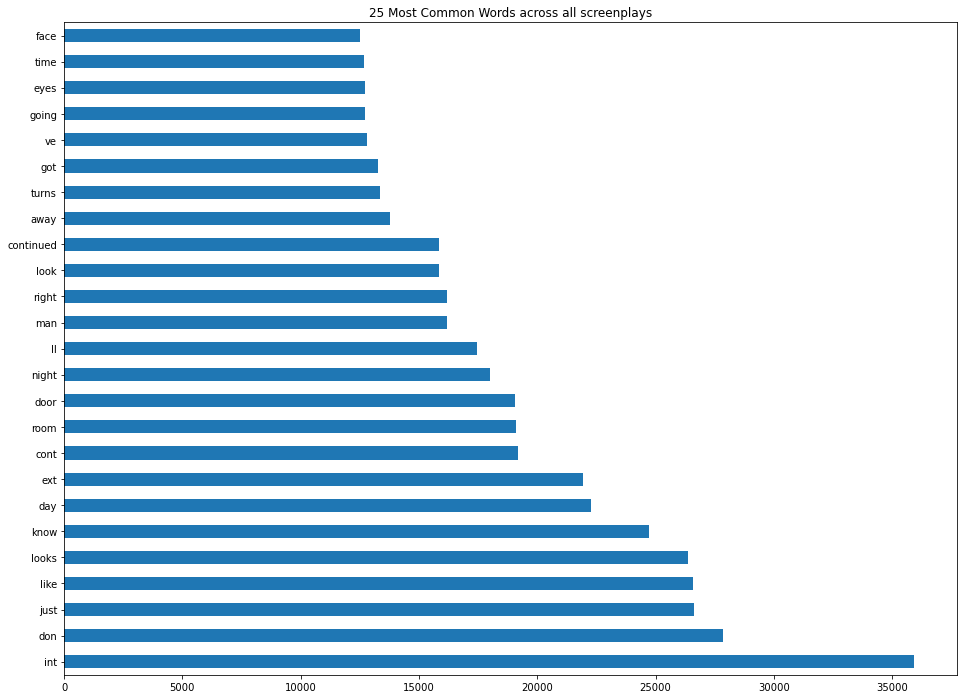

In [13]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common Words across all screenplays')
count_bechdel_cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

#### Bigram time!

Here we are looking at bigrams to see the different two word combos.

In [14]:
bigram_bechdel = CountVectorizer(ngram_range=(2,2), stop_words='english')
bigram_bechdel_x = bigram_bechdel.fit_transform(bechdel_df['textscript'])
bigram_bechdel_x

<431x3174370 sparse matrix of type '<class 'numpy.int64'>'
	with 4493136 stored elements in Compressed Sparse Row format>

In [15]:
bigram_bechdel_df = pd.DataFrame(bigram_bechdel_x.todense(), columns=bigram_bechdel.get_feature_names())

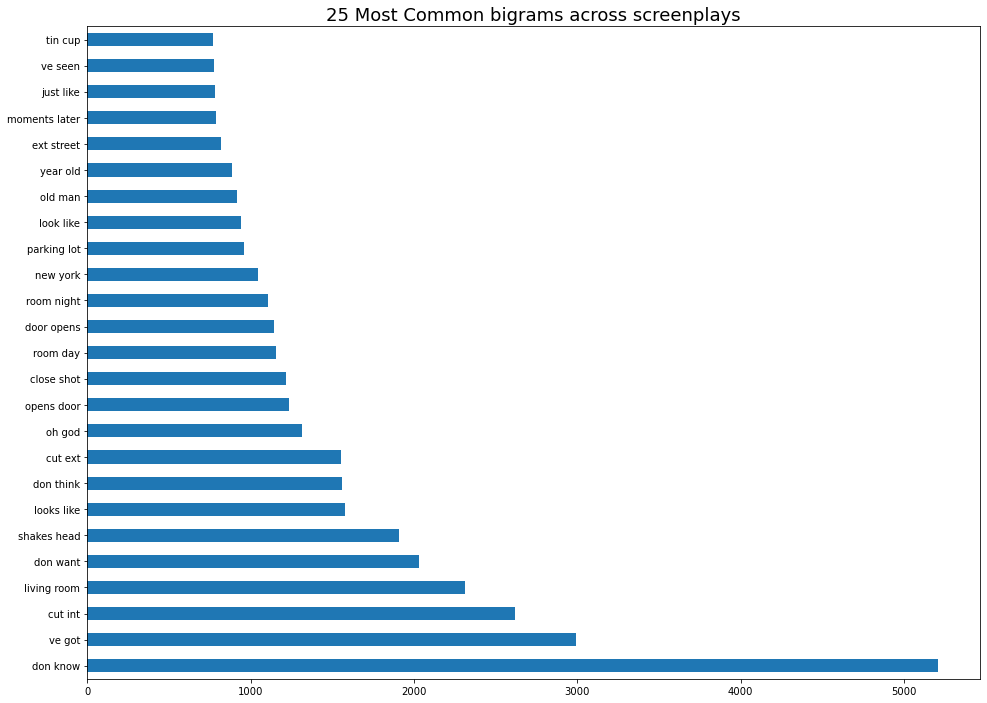

In [17]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common bigrams across screenplays', fontdict={'fontsize':18})
bigram_bechdel_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Let's explore the data through some trigrams:

I think the combination of words into phrases could be useful here.

In [31]:
trigram_madmen = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)
trigram_madmen_x = trigram_madmen.fit_transform(madmen_df['total_text'])
trigram_madmen_x

<3000x56233 sparse matrix of type '<class 'numpy.int64'>'
	with 57564 stored elements in Compressed Sparse Row format>

In [32]:
trigram_madmen_df = pd.DataFrame(trigram_madmen_x.todense(), columns=trigram_madmen.get_feature_names())

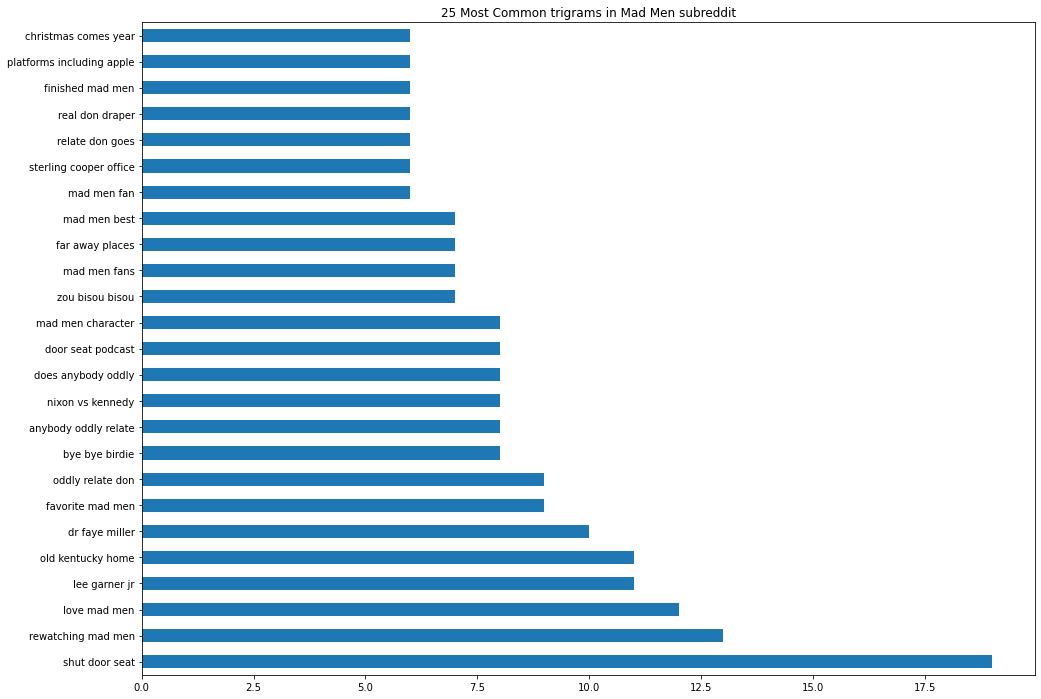

In [33]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common trigrams in Mad Men subreddit')
trigram_madmen_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

And now let's do some of this for The Sopranos too now.

In [34]:
trigram_sopranos = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)
trigram_sopranos_x = trigram_sopranos.fit_transform(sopranos_df['total_text'])
trigram_sopranos_x

<3000x72998 sparse matrix of type '<class 'numpy.int64'>'
	with 74199 stored elements in Compressed Sparse Row format>

In [35]:
trigram_sopranos_df = pd.DataFrame(trigram_sopranos_x.todense(), columns=trigram_sopranos.get_feature_names())

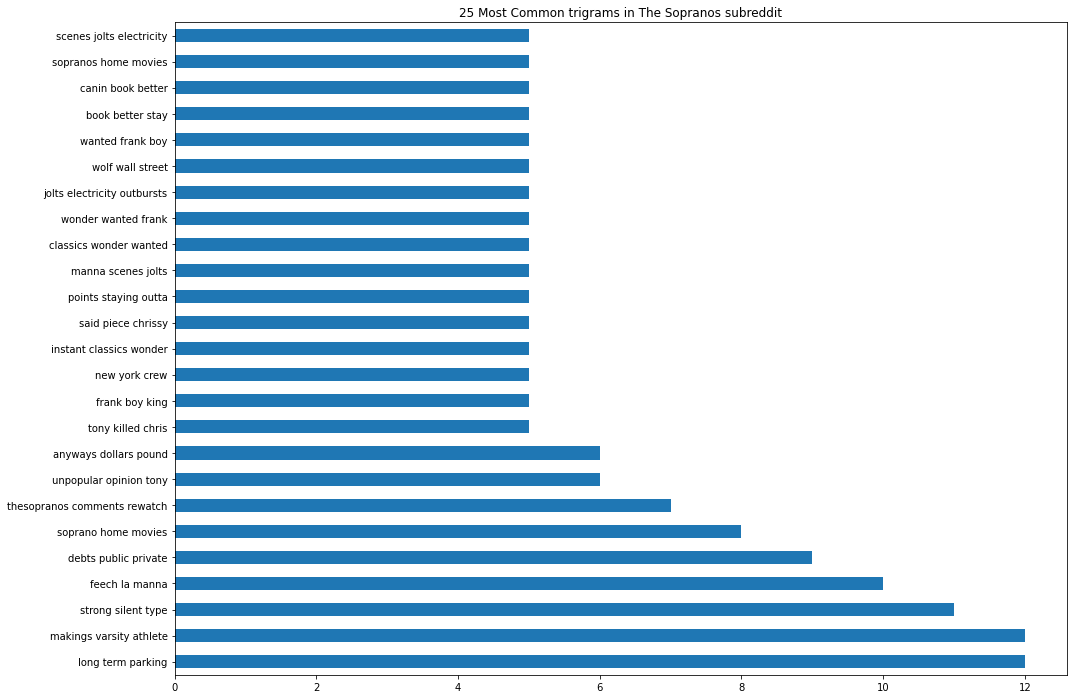

In [36]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common trigrams in The Sopranos subreddit')
trigram_sopranos_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

Exploring bigrams and trigrams gave some much needed insight into our data and what is common and different between the two subreddits. I ran these bigrams and trigrams multiple times, adding to my list of stop words with each iteration until arriving at the graphs that you see above. 

# The Modeling Begins!

In [18]:
X = bechdel_df['textscript']
y = bechdel_df['simple_bechdel']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [19]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression())
        
])

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('logreg', LogisticRegression())])

In [21]:
pipe.score(X_train, y_train)

1.0

In [22]:
pipe.score(X_test, y_test)

0.48148148148148145

1?!?! It appears my model is overfit. I am curious as to what is causing the difference.

In [23]:
preds = pipe.predict(X_test)

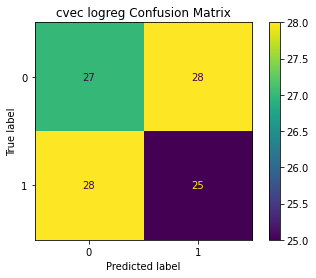

In [25]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('cvec logreg Confusion Matrix');

In [26]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49        55
           1       0.47      0.47      0.47        53

    accuracy                           0.48       108
   macro avg       0.48      0.48      0.48       108
weighted avg       0.48      0.48      0.48       108



#### Let's try out another model: TfidfVectorizer with Bernoulli Naive Bayes

In [28]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', BernoulliNB())
])

In [29]:
pipe_tvec_nb.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(stop_words='english')),
                ('nb', BernoulliNB())])

In [30]:
pipe_tvec_nb.score(X_train, y_train)

0.978328173374613

In [31]:
pipe_tvec_nb.score(X_test, y_test)

0.5277777777777778

Well, this is better than the information from the logistic regression and count vectorizer. At least we are now in the MVP territory!

In [32]:
pipe_tvec_nb_preds = pipe_tvec_nb.predict(X_test)

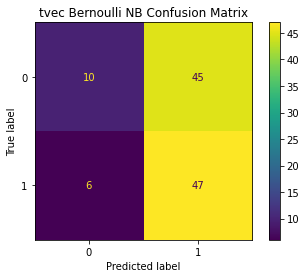

In [33]:
cm = confusion_matrix(y_test, pipe_tvec_nb_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('tvec Bernoulli NB Confusion Matrix');

In [34]:
print(classification_report(y_test, pipe_tvec_nb_preds))

              precision    recall  f1-score   support

           0       0.62      0.18      0.28        55
           1       0.51      0.89      0.65        53

    accuracy                           0.53       108
   macro avg       0.57      0.53      0.46       108
weighted avg       0.57      0.53      0.46       108



# Going with another model that involves gridsearch


Okay I ran this once and it took hours. We cannot do this a second time. Please don't you dare do this a second time. What a waste.

In [35]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [36]:
params = {
    'knn__n_neighbors': range(1,100,2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

In [37]:
knn_gs = GridSearchCV(
    pipe_knn,
    params,
    cv=5
)

In [38]:
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': range(1, 100, 2),
                         'knn__weights': ['uniform', 'distance']})

In [39]:
knn_gs.best_score_

0.6070192307692308

In [40]:
knn_gs.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__metric': 'euclidean',
 'knn__n_neighbors': 13,
 'knn__weights': 'distance'}

In [41]:
knn_gs_preds = knn_gs.predict(X_test)

In [42]:
print(classification_report(y_test, knn_gs_preds))

              precision    recall  f1-score   support

           0       0.58      0.82      0.68        55
           1       0.68      0.40      0.50        53

    accuracy                           0.61       108
   macro avg       0.63      0.61      0.59       108
weighted avg       0.63      0.61      0.59       108



#### Another K-NN model made that did not include GridSearch this time around, as I kept running my models as I cleaned the data and added stop words to the list.

This model was included in my presentation.

In [44]:
pipe_knn_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [45]:
pipe_knn_2.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('knn', KNeighborsClassifier())])

In [46]:
pipe_knn_2.score(X_train, y_train)

0.5603715170278638

In [47]:
pipe_knn_2.score(X_test, y_test)

0.5185185185185185

In [48]:
knn_2_preds = pipe_knn_2.predict(X_test)

In [49]:
print(classification_report(y_test, knn_2_preds))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67        55
           1       0.67      0.04      0.07        53

    accuracy                           0.52       108
   macro avg       0.59      0.51      0.37       108
weighted avg       0.59      0.52      0.38       108



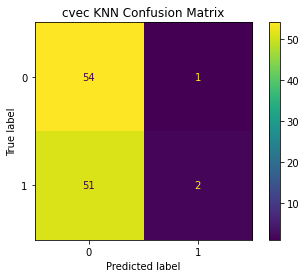

In [51]:
cm = confusion_matrix(y_test, knn_2_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()
plt.title('cvec KNN Confusion Matrix');

This model has an incredibly bad recall score.